Import modules

In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Data import

In [3]:
raw_data_path = 'C:/Users/49152/Downloads/GSE242894/raw_data/'
data_source = {'GSM7774436':'GSM7774436_coculture1_hi_rc.txt','GSM7774437':'GSM7774437_coculture2_hi_rc.txt',
               'GSM7774438':'GSM7774438_coculture3_hi_rc.txt','GSM7774439':'GSM7774439_organoid1_hi_rc.txt',
               'GSM7774440':'GSM7774440_organoid2_hi_rc.txt','GSM7774441':'GSM7774441_organoid3_hi_rc.txt',
               'GSM7774442':'GSM7774442_iMac1_hi_rc.txt','GSM7774443':'GSM7774443_iMac2_hi_rc.txt'}
sample=['GSM7774436','GSM7774437','GSM7774438','GSM7774439','GSM7774440','GSM7774441','GSM7774442','GSM7774443']

In [4]:
for i in range(len(sample)):
    globals()[sample[i]] =  sc.read_text(raw_data_path+data_source[sample[i]], delimiter='\t', first_column_names=True)
    globals()[sample[i]] = globals()[sample[i]].T
    globals()[sample[i]].var_names_make_unique()
adata = GSM7774436.concatenate(GSM7774437, GSM7774438, GSM7774439,GSM7774440,GSM7774441,GSM7774442,GSM7774443,batch_key = "Sample")
rename = []
for j in range(len(adata)):
    rename.append(adata.obs.index[j][0:-2])
adata.obs.index = rename

Subsetting NPC & neuron observations

In [19]:
cell_md = pd.read_csv(raw_data_path+"metadata_all_cells.csv", index_col=0)

In [21]:
subset = cell_md[cell_md["cell_type"].isin(["neuron", "co-neuron", "NPC", "co-NPC"])]
subset

,Sample,leiden,cell_type
AAACCTGAGCTAACAA-co1,Coculture_organoid_1,6,co-NPC
AAACCTGAGGCAGGTT-co1,Coculture_organoid_1,2,co-NPC
AAACCTGCACGTCTCT-co1,Coculture_organoid_1,2,co-NPC
AAACCTGGTCTGCCAG-co1,Coculture_organoid_1,2,co-NPC
AAACCTGGTGTCGCTG-co1,Coculture_organoid_1,1,co-neuron
...,...,...,...
TTTGGTTTCCCTAACC-or3,Mono_organoid_3,4,neuron
TTTGTCAAGATTACCC-or3,Mono_organoid_3,4,neuron
TTTGTCAAGTAATCCC-or3,Mono_organoid_3,2,NPC
TTTGTCAAGTGCGTGA-or3,Mono_organoid_3,2,NPC


Remove Sample column

In [24]:
subset = subset.drop(['Sample'], axis='columns')
subset

,leiden,cell_type
AAACCTGAGCTAACAA-co1,6,co-NPC
AAACCTGAGGCAGGTT-co1,2,co-NPC
AAACCTGCACGTCTCT-co1,2,co-NPC
AAACCTGGTCTGCCAG-co1,2,co-NPC
AAACCTGGTGTCGCTG-co1,1,co-neuron
...,...,...
TTTGGTTTCCCTAACC-or3,4,neuron
TTTGTCAAGATTACCC-or3,4,neuron
TTTGTCAAGTAATCCC-or3,2,NPC
TTTGTCAAGTGCGTGA-or3,2,NPC


Filter adata to match with subset

In [27]:
adata = adata[subset.index].copy()
adata

AnnData object with n_obs × n_vars = 6862 × 33660
    obs: 'Sample'

Combine metadata with adata

In [29]:
adata.obs = pd.merge(adata.obs, subset, left_index=True, right_index=True)
adata.obs

,Sample,leiden,cell_type
AAACCTGAGCTAACAA-co1,0,6,co-NPC
AAACCTGAGGCAGGTT-co1,0,2,co-NPC
AAACCTGCACGTCTCT-co1,0,2,co-NPC
AAACCTGGTCTGCCAG-co1,0,2,co-NPC
AAACCTGGTGTCGCTG-co1,0,1,co-neuron
...,...,...,...
TTTGGTTTCCCTAACC-or3,5,4,neuron
TTTGTCAAGATTACCC-or3,5,4,neuron
TTTGTCAAGTAATCCC-or3,5,2,NPC
TTTGTCAAGTGCGTGA-or3,5,2,NPC


Adding a column to indicte cluster & cell type

In [33]:
adata.obs["cell_type_cluster"] = adata.obs["leiden"].astype(str) + "_" + adata.obs["cell_type"]
adata.obs

,Sample,leiden,cell_type,cell_type_cluster
AAACCTGAGCTAACAA-co1,0,6,co-NPC,6_co-NPC
AAACCTGAGGCAGGTT-co1,0,2,co-NPC,2_co-NPC
AAACCTGCACGTCTCT-co1,0,2,co-NPC,2_co-NPC
AAACCTGGTCTGCCAG-co1,0,2,co-NPC,2_co-NPC
AAACCTGGTGTCGCTG-co1,0,1,co-neuron,1_co-neuron
...,...,...,...,...
TTTGGTTTCCCTAACC-or3,5,4,neuron,4_neuron
TTTGTCAAGATTACCC-or3,5,4,neuron,4_neuron
TTTGTCAAGTAATCCC-or3,5,2,NPC,2_NPC
TTTGTCAAGTGCGTGA-or3,5,2,NPC,2_NPC


Rename index to match with loom file

In [36]:
rename = []
for i in range(len(adata)):
    rename.append(adata.obs.index[i][0:16]+adata.obs.iloc[i]['Sample'])
adata.obs.index = rename

Loom file loading, index rename & subsetting

In [39]:
ldata =  sc.read(raw_data_path+'combined.loom')

In [40]:
sample_dict = {'GSM7774436':'0','GSM7774437':'1','GSM7774438':'2','GSM7774439':'3','GSM7774440':'4',
               'GSM7774441':'5','GSM7774442':'6','GSM7774443':'7'}
rename = []
for i in range(len(ldata)):
    rename.append(ldata.obs.index[i][11:27]+sample_dict[ldata.obs.index[i][0:10]])
ldata.obs.index = rename
ldata = ldata[adata.obs.index].copy()
ldata

AnnData object with n_obs × n_vars = 6862 × 36601
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Data merging

In [42]:
adata = scv.utils.merge(adata, ldata)

Data type changing

In [44]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

saving figure to file C:/Users/49152/Downloads/GSE242894/Figures/scvelo_proportions__unsp_sp_proportion.png


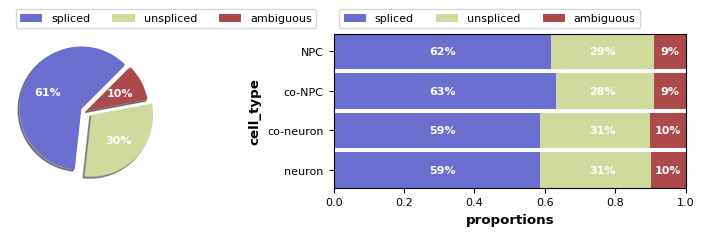

In [49]:
scv.settings.figdir = 'C:/Users/49152/Downloads/GSE242894/Figures/'
#scv.pl.proportions(adata,groupby='leiden')
scv.pl.proportions(adata,groupby='cell_type', save = '_unsp_sp_proportion.png')

Normalization & log-transformation

In [164]:
scv.pp.filter_and_normalize(adata)

Normalized count data: X, spliced, unspliced.


C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.


Moment calculation

In [168]:
scv.pp.moments(adata)

C:\Users\49152\AppData\Local\Temp\ipykernel_31900\3618267578.py:1: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata)
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\preprocessing\neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [170]:
scv.tl.velocity(adata)

computing velocities


C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [172]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [182]:
adata.obs

,Sample,leiden,cell_type,cell_type_cluster,initial_size_unspliced,initial_size_spliced,initial_size,cluster,n_counts,velocity_self_transition
AAACCTGAGCTAACAA0,0,6,co-NPC,6_co-NPC,2643.0,6905.0,6905.0,co-NPC,9636.550781,0.148549
AAACCTGAGGCAGGTT0,0,2,co-NPC,2_co-NPC,4421.0,12673.0,12673.0,co-NPC,11416.140625,0.111625
AAACCTGCACGTCTCT0,0,2,co-NPC,2_co-NPC,2569.0,5603.0,5603.0,co-NPC,8093.272949,0.092675
AAACCTGGTCTGCCAG0,0,2,co-NPC,2_co-NPC,1870.0,4319.0,4319.0,co-NPC,11065.631836,0.083373
AAACCTGGTGTCGCTG0,0,1,co-neuron,1_co-neuron,2554.0,7210.0,7210.0,co-neuron,10204.191406,0.090459
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCCTAACC5,5,4,neuron,4_neuron,1791.0,3805.0,3805.0,neuron,9411.000977,0.093657
TTTGTCAAGATTACCC5,5,4,neuron,4_neuron,2519.0,5623.0,5623.0,neuron,9245.128906,0.091818
TTTGTCAAGTAATCCC5,5,2,NPC,2_NPC,3420.0,7610.0,7610.0,NPC,8880.833984,0.071852
TTTGTCAAGTGCGTGA5,5,2,NPC,2_NPC,2264.0,5108.0,5108.0,NPC,10706.306641,0.058316


Computing umap

In [191]:
sc.tl.umap(adata)

Velocity visualization

C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWa

saving figure to file C:/Users/49152/Downloads/GSE242894/Figures/scvelo__cell_type.png


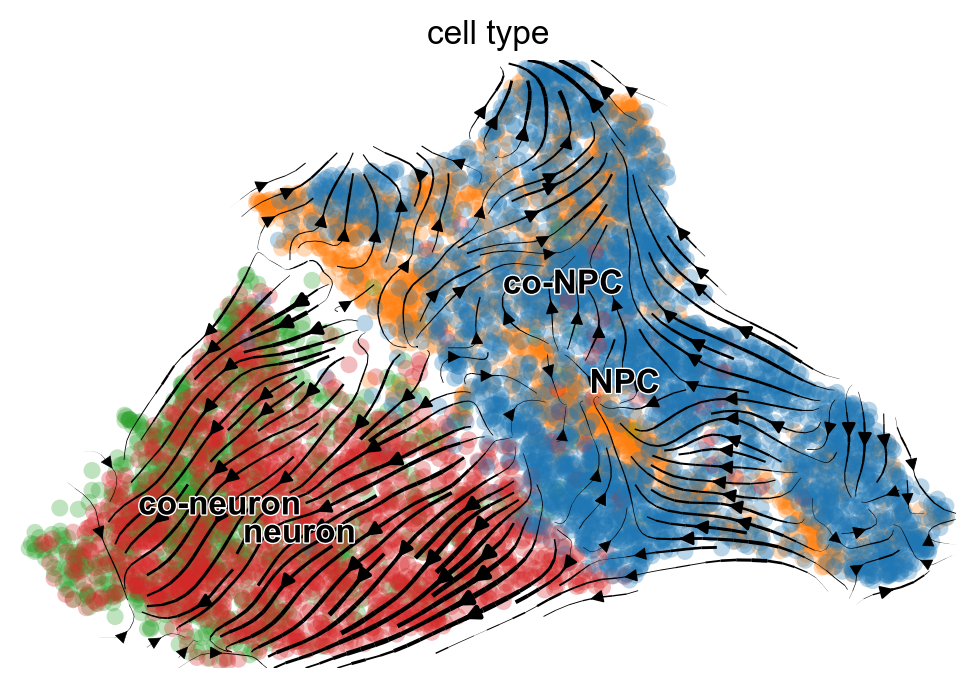

In [208]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color = 'cell_type', save = '_cell_type.png')

C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWa

saving figure to file C:/Users/49152/Downloads/GSE242894/Figures/scvelo__cell_type_cluster.png


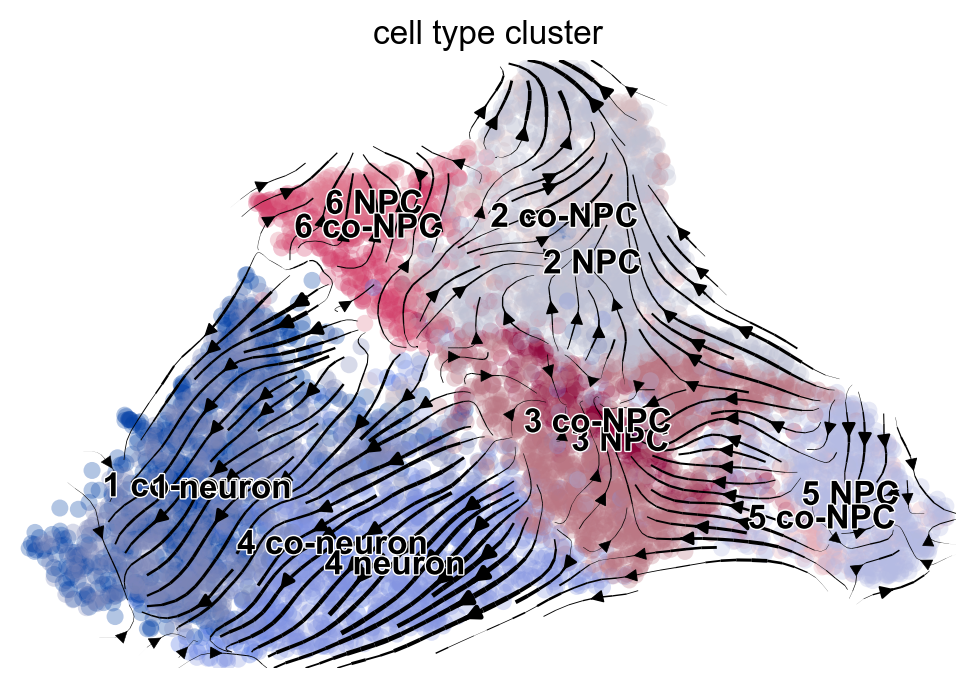

In [210]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color = 'cell_type_cluster', save = '_cell_type_cluster.png')

Velocity graph and pseudotime

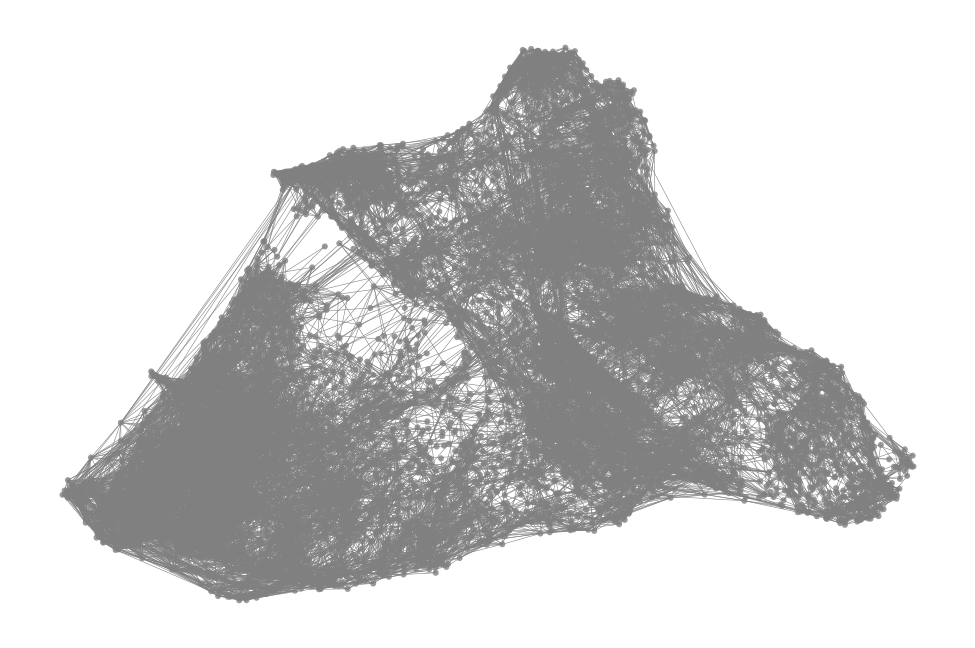

In [202]:
scv.pl.velocity_graph(adata, threshold=.1)

In [200]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\49152\anaconda3\envs\scv\lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWa

saving figure to file C:/Users/49152/Downloads/GSE242894/Figures/scvelo__cell_type_cluster_pseudotime.png


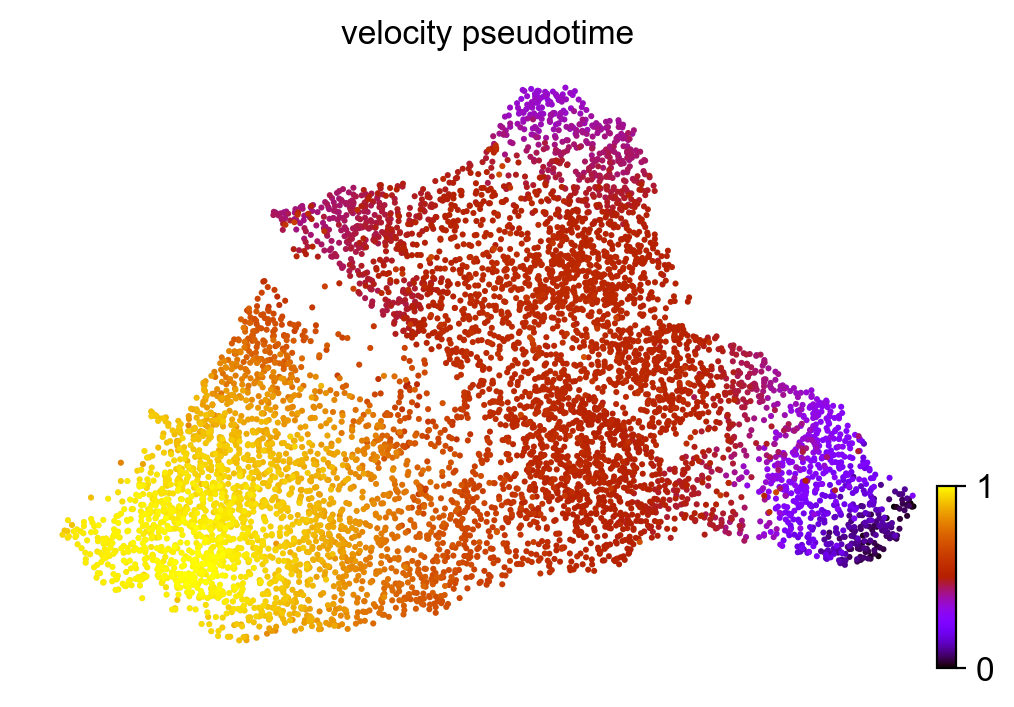

In [212]:
scv.pl.scatter(adata, color=['velocity_pseudotime'], cmap='gnuplot', groups=adata.obs['cell_type_cluster'], save = '_cell_type_cluster_pseudotime.png')